In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from scipy.stats import norm
from datetime import datetime, time 

import pickle

## Importing hand-made modules - Change scraper_modules_path to folder containing custom modules
import sys
scraper_modules_path = 'C:/Users/ABour/Desktop/Energy Systems & Data Analytics/Modules/Energy Analysis - Aidan/Smart Meters/custom_modules'
if scraper_modules_path not in sys.path:
    sys.path.append(scraper_modules_path)

import pre_processing as pp

<br>

### Reading In & Cleaning Data

In [63]:
batch = 5
df_smart_meters = pd.read_pickle(f'data/batch_{batch}.pkl')

In [128]:
## Separating out subset of data for analysis
test_ids = df_smart_meters.id.unique()[:10]
df_test = (df_smart_meters.copy()[df_smart_meters.id.isin(test_ids)]
           .drop(columns='stdorToU'))

## Creating SP Column
dt_values = df_test['datetime']
df_test['SP'] = dt_values.apply(pp.time_2_SP)

## Separating out ToU and std tariff periods
std_bool = df_test.datetime.dt.year!=2013
df_test_std = df_test.copy()[std_bool]
df_test_ToU = df_test.copy()[~std_bool]

df_test_ToU.head(10)

,id,datetime,kWh,SP
134158912,MAC000005,2013-01-01 00:00:00,0.096,1
134158913,MAC000005,2013-01-01 00:30:00,0.111,2
134158914,MAC000005,2013-01-01 01:00:00,0.071,3
134158915,MAC000005,2013-01-01 01:30:00,0.035,4
134158916,MAC000005,2013-01-01 02:00:00,0.035,5
134158917,MAC000005,2013-01-01 02:30:00,0.034,6
134158918,MAC000005,2013-01-01 03:00:00,0.035,7
134158919,MAC000005,2013-01-01 03:30:00,0.03,8
134158920,MAC000005,2013-01-01 04:00:00,0.028,9
134158921,MAC000005,2013-01-01 04:30:00,0.03,10


In [129]:
## Reading in ToU price data
df_ToU_price_raw = (pd.read_csv('data/tariff_d.csv', parse_dates=['GMT'])
                    .rename({'GMT':'datetime', 'Price':'price', 'Event_tags':'event'}, axis=1))
df_ToU_price_raw.head(10)

,datetime,price,event
0,2013-01-01 00:30:00,0.1176,NaN
1,2013-01-01 01:00:00,0.1176,NaN
2,2013-01-01 01:30:00,0.1176,NaN
3,2013-01-01 02:00:00,0.1176,NaN
4,2013-01-01 02:30:00,0.1176,NaN
5,2013-01-01 03:00:00,0.1176,NaN
6,2013-01-01 03:30:00,0.1176,NaN
7,2013-01-01 04:00:00,0.1176,NaN
8,2013-01-01 04:30:00,0.1176,NaN
9,2013-01-01 05:00:00,0.1176,NaN


In [130]:
def clean_and_extract_price(df_ToU_price):
    df_ToU_price = (df_ToU_price[df_ToU_price.datetime.dt.year==2013] # Dropping spare day at start of 2014
                    .drop(columns=['event']) # Drop unnecessary columns
                    .set_index('datetime')) # Set datetime as index
    return df_ToU_price

df_price = clean_and_extract_price(df_ToU_price_raw.copy())
df_price.head(10)

,price
datetime,
2013-01-01 00:30:00,0.1176
2013-01-01 01:00:00,0.1176
2013-01-01 01:30:00,0.1176
2013-01-01 02:00:00,0.1176
2013-01-01 02:30:00,0.1176
2013-01-01 03:00:00,0.1176
2013-01-01 03:30:00,0.1176
2013-01-01 04:00:00,0.1176
2013-01-01 04:30:00,0.1176


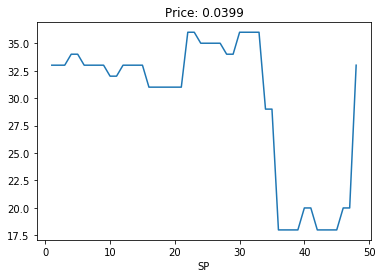

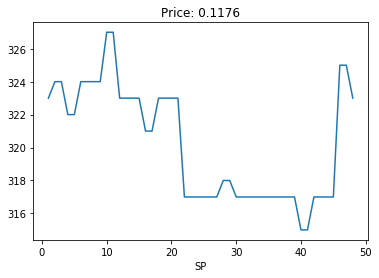

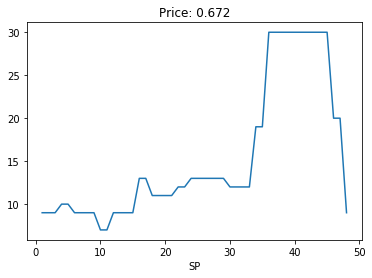

In [6]:
## Grouping ToU TS Prices by SP and Price
df_ToU_price = df_ToU_price_raw.copy()
dt_values = df_ToU_price['datetime']
df_ToU_price['SP'] = dt_values.apply(pp.time_2_SP)

df_ToU_price_groupby = df_ToU_price.groupby(['price', 'SP']).price.count().unstack().T

## Plotting ToU Prices Distributions with SP
prices = [0.0399, 0.1176, 0.672]

for price in prices:
    plt.figure()
    df_ToU_price_groupby[price].plot()
    plt.title(f'Price: {price}')

<br>

### Demand Side Response Quantification - Test Subset

In [138]:
_id = test_ids[0]

def create_df_household(df_ToU, df_price, _id):
    df_household = (
                    df_ToU.copy() # Set as copy of df_ToU
                    [df_ToU.id==_id] # Filter for household id
                    .drop(columns='id') # Drop id column
                    .set_index('datetime') # Set index as datetime column
                    .assign(price=df_price.price) # Set price according to price df
                    .dropna() # Drop NA values
                    .astype('float') # Setting data types to float
    ) 
    return df_household

df_household = create_df_household(df_test_ToU, df_price, _id)
df_household.head(10)

,kWh,SP,price
datetime,,,
2013-01-01 00:30:00,0.111,2.0,0.1176
2013-01-01 01:00:00,0.071,3.0,0.1176
2013-01-01 01:30:00,0.035,4.0,0.1176
2013-01-01 02:00:00,0.035,5.0,0.1176
2013-01-01 02:30:00,0.034,6.0,0.1176
2013-01-01 03:00:00,0.035,7.0,0.1176
2013-01-01 03:30:00,0.030,8.0,0.1176
2013-01-01 04:00:00,0.028,9.0,0.1176
2013-01-01 04:30:00,0.030,10.0,0.1176


In [9]:
SPs = list(df_household.SP.unique())
SPs.sort()

plot_SP_price_dist = False
if plot_SP_price_dist==True:
    for SP in SPs:
        df_household_filtered_SP = df_household[df_household.SP==SP] # Filter on SP
        df_household_filtered_SP = df_household_filtered_SP[(df_household_filtered_SP.index.dayofweek>4)] # Dropping weekend

        plt.figure()
        for price in prices:
            df_household_filtered_SP_price = df_household_filtered_SP[df_household_filtered_SP.price==price].drop(columns=['price']) # Filter on price

            sns.distplot(df_household_filtered_SP_price.kWh, label=f'{price}')

        plt.title(f'SP: {int(SP)}')
        plt.legend(title='Price')
        plt.ylim(0, 20)
        plt.xlim(0, 0.5)

In [10]:
household_dict = dict()

def add_df_household_DSR_2_dict(df_household_filtered, household_dict):
    household_dict['SPs'] = dict()
    
    for SP in SPs:
        # Filter on SP
        df_household_filtered_SP = df_household_filtered[df_household_filtered.SP==SP]
        household_dict['SPs'][SP] = dict()

        for price in prices:
            # Filter on price
            df_household_filtered_SP_price = df_household_filtered_SP[df_household_filtered_SP.price==price].drop(columns=['price'])

            mean_price = df_household_filtered_SP_price.kWh.mean()
            household_dict['SPs'][SP][price] = mean_price

    return household_dict
        
df_household_filtered = df_household.copy()#[(df_household.index.dayofweek>4)] # Dropping weekend
household_dict = add_df_household_DSR_2_dict(df_household_filtered, household_dict)

<Figure size 432x288 with 0 Axes>

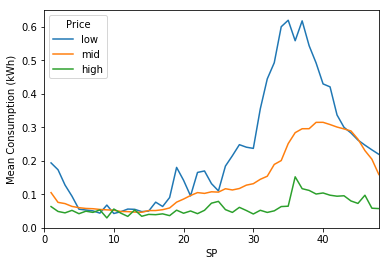

In [22]:
def plot_household_DSR(household_dict):
    plt.figure()
    pd.DataFrame(household_dict['SPs']).T.plot()
    plt.legend(title='Price', labels=['low', 'mid', 'high'])
    plt.xlabel('SP')
    plt.ylabel('Mean Consumption (kWh)')
    plt.xlim(1, 48)
    plt.xlim(0)
    
plot_household_DSR(household_dict)

<Figure size 432x288 with 0 Axes>

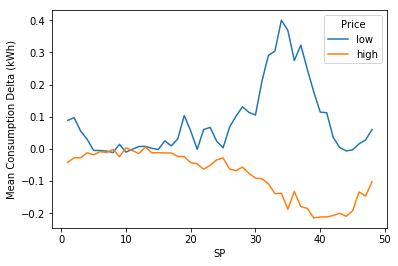

In [27]:
def plot_household_DSR_delta(household_dict):
    df_household_DSR = pd.DataFrame(household_dict['SPs']).T
    df_household_DSR_delta = df_household_DSR.copy()
    df_household_DSR_delta[prices[0]] -= df_household_DSR_delta[prices[1]]
    df_household_DSR_delta[prices[2]] -= df_household_DSR_delta[prices[1]]
    df_household_DSR_delta = df_household_DSR_delta.drop(columns=prices[1])
    
    plt.figure()
    df_household_DSR_delta.plot()
    plt.legend(title='Price', labels=['low', 'high'])
    plt.xlabel('SP')
    plt.ylabel('Mean Consumption Delta (kWh)')
    
plot_household_DSR_delta(household_dict)

In [13]:
def add_s_household_DSR_2_dict(household_dict):
    s_household_DSR = pd.DataFrame(household_dict['SPs']).T.mean()
    household_dict['s_DSR'] = s_household_DSR
    return household_dict

household_dict = add_s_household_DSR_2_dict(household_dict)
household_dict['s_DSR']

0.0399    0.093163
0.1176    0.094761
0.6720    0.091179
dtype: float64

In [35]:
def add_deltas_2_household_dict(household_dict):
    s_DSR = household_dict['s_DSR']
    mid_consumption = s_DSR.loc[prices[1]]
    household_dict['low_delta'] = s_DSR.loc[prices[0]] - mid_consumption
    household_dict['high_delta'] = s_DSR.loc[prices[2]] - mid_consumption
    return household_dict

household_dict = add_deltas_2_household_dict(household_dict)
print(f'Low Delta: {household_dict["low_delta"]}')
print(f'High Delta: {household_dict["high_delta"]}')

Low Delta: 0.08604051717029804
High Delta: -0.08081042769039518


In [44]:
def create_household_dict(df_test_ToU, _id):
    df_household = create_df_household(df_test_ToU, _id)

    household_dict = dict()
    household_dict = add_df_household_DSR_2_dict(df_household, household_dict)
    household_dict = add_s_household_DSR_2_dict(household_dict)
    household_dict = add_deltas_2_household_dict(household_dict)

    return household_dict

households_dict = dict()
for _id in test_ids:
    households_dict[_id] = create_household_dict(df_test_ToU, _id)

In [69]:
plot_DSR = False
if plot_DSR == True:
    for _id in test_ids:
        household_dict = households_dict[_id]
        plot_household_DSR(household_dict)
        plt.title(f'{_id} DSR')

In [70]:
plot_DSR_delta = False
if plot_DSR_delta == True:
    for _id in test_ids:
        household_dict = households_dict[_id]
        plot_household_DSR_delta(household_dict)
        plt.title(f'{_id} DSR Delta')

<br>

### Demand Side Response Quantification - Full Dataset

In [71]:
batch = 5
df_smart_meters = pd.read_pickle(f'data/batch_{batch}.pkl')

## Separating out subset of data for analysis
df_smart_meters = df_smart_meters.copy().drop(columns='stdorToU')

## Creating SP Column
dt_values = df_smart_meters['datetime']
df_smart_meters['SP'] = dt_values.apply(pp.time_2_SP)

## Separating out ToU and std tariff periods
std_bool = df_smart_meters.datetime.dt.year!=2013
df_std = df_smart_meters.copy()[std_bool]
df_ToU = df_smart_meters.copy()[~std_bool]

df_ToU.head(10)

,id,datetime,kWh,SP
134158912,MAC000005,2013-01-01 00:00:00,0.096,1
134158913,MAC000005,2013-01-01 00:30:00,0.111,2
134158914,MAC000005,2013-01-01 01:00:00,0.071,3
134158915,MAC000005,2013-01-01 01:30:00,0.035,4
134158916,MAC000005,2013-01-01 02:00:00,0.035,5
134158917,MAC000005,2013-01-01 02:30:00,0.034,6
134158918,MAC000005,2013-01-01 03:00:00,0.035,7
134158919,MAC000005,2013-01-01 03:30:00,0.03,8
134158920,MAC000005,2013-01-01 04:00:00,0.028,9
134158921,MAC000005,2013-01-01 04:30:00,0.03,10


In [53]:
households_dict = dict()
ids = df_smart_meters.id.unique()

for _id in ids:
    households_dict[_id] = create_household_dict(df_ToU, _id)
    
save_dict = True
if save_dict== True:
    with open('data/household_ToU_response.pickle', 'wb') as handle:
        pickle.dump(households_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [54]:
low_deltas = []
high_deltas = []

for _id in ids:
    household_dict = households_dict[_id]
    low_deltas.append(household_dict['low_delta'])
    high_deltas.append(household_dict['high_delta'])

In [81]:
df_deltas = pd.DataFrame(data={'low_delta':low_deltas, 'high_delta':high_deltas}, index=ids).dropna()
df_deltas.index.name = 'id'
df_deltas.head(10)

,low_delta,high_delta
id,,
MAC000005,-0.001598,-0.003581
MAC000014,0.011381,-0.003582
MAC000015,-0.007697,0.001565
MAC000017,0.098132,-0.045838
MAC000031,0.033303,0.036883
MAC000044,0.010923,-0.050551
MAC000046,0.065520,-0.046107
MAC000048,-0.012223,0.014594
MAC000051,0.196741,-0.036397


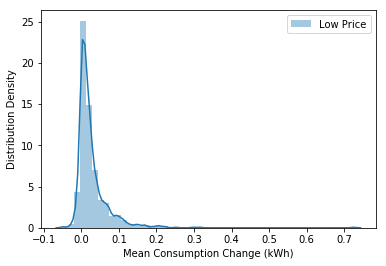

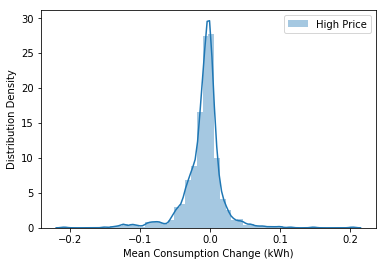

In [79]:
plt.figure()
sns.distplot(df_deltas.low_delta, label='Low Price')
plt.xlabel('Mean Consumption Change (kWh)')
plt.ylabel('Distribution Density')
plt.legend()

plt.figure()
sns.distplot(df_deltas.high_delta, label='High Price')
plt.xlabel('Mean Consumption Change (kWh)')
plt.ylabel('Distribution Density')
plt.legend()

<br>

### Demand Side Response Analysis

In [127]:
# Use magnitude of combined DSR response to rank households on their behaviour change
## Compare against combining ranks from individual DSRs of high and low

df_deltas['combined_DRS'] = df_deltas.low_delta - df_deltas.high_delta
df_deltas['DRS_rank'] = df_deltas.combined_DRS.rank().astype('int')

df_deltas = df_deltas.sort_values(by='DRS_rank', ascending=False)
df_deltas.to_csv('data/DSR_deltas.csv')

df_deltas.head(10)

,low_delta,high_delta,combined_DRS,DRS_rank
id,,,,
MAC000512,0.725933,-0.151500,0.877433,1117
MAC005401,0.298254,-0.124619,0.422872,1116
MAC002839,0.217107,-0.131646,0.348754,1115
MAC004497,0.200898,-0.128524,0.329422,1114
MAC005162,0.250627,-0.077210,0.327837,1113
MAC005413,0.187678,-0.135476,0.323154,1112
MAC003713,0.222972,-0.093342,0.316314,1111
MAC000065,0.205598,-0.090087,0.295685,1110
MAC003502,0.207437,-0.079572,0.287009,1109


(-0.15, 0.05)

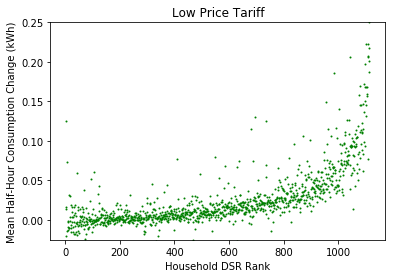

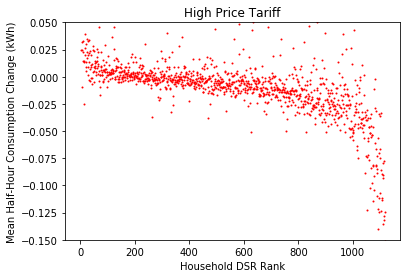

In [114]:
plt.figure()
plt.scatter(df_deltas.DRS_rank , df_deltas.low_delta, s=1, c='g')
plt.xlabel('Household DSR Rank')
plt.ylabel('Mean Half-Hour Consumption Change (kWh)')
plt.title('Low Price Tariff')
plt.ylim(-0.025, 0.25)

plt.figure()
plt.scatter(df_deltas.DRS_rank , df_deltas.high_delta, s=1, c='r')
plt.xlabel('Household DSR Rank')
plt.ylabel('Mean Half-Hour Consumption Change (kWh)')
plt.title('High Price Tariff')
plt.ylim(-0.15, 0.05)

<Figure size 432x288 with 0 Axes>

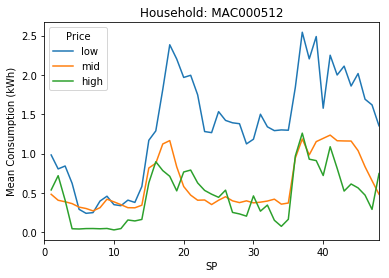

<Figure size 432x288 with 0 Axes>

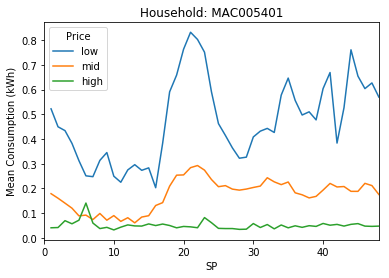

<Figure size 432x288 with 0 Axes>

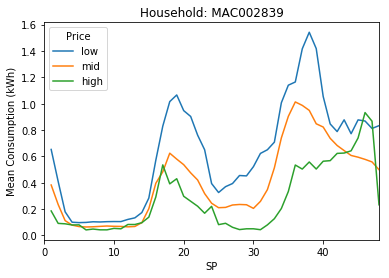

<Figure size 432x288 with 0 Axes>

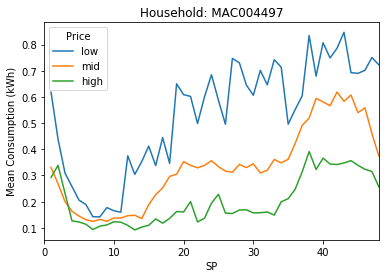

<Figure size 432x288 with 0 Axes>

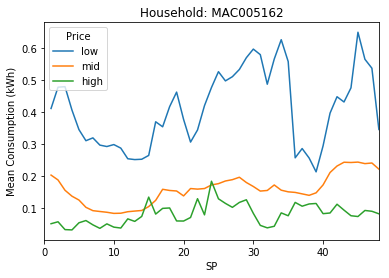

In [125]:
for _id in df_deltas.iloc[:5].index:
    household_dict = households_dict[_id]
    plot_household_DSR(household_dict)
    plt.title(f'Household: {_id}')

<Figure size 432x288 with 0 Axes>

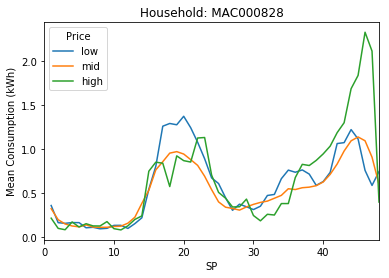

<Figure size 432x288 with 0 Axes>

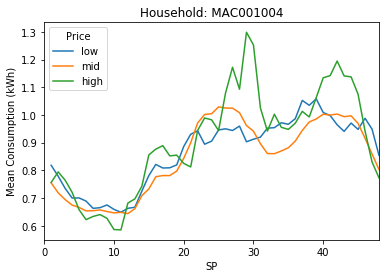

<Figure size 432x288 with 0 Axes>

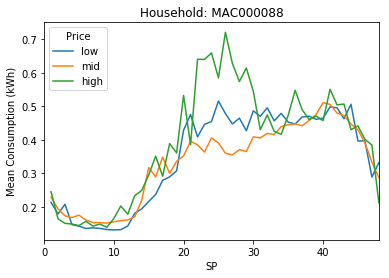

<Figure size 432x288 with 0 Axes>

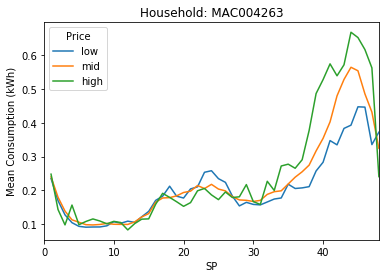

<Figure size 432x288 with 0 Axes>

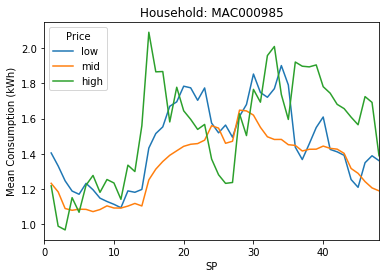

In [124]:
for _id in df_deltas.iloc[-5:].index:
    household_dict = households_dict[_id]
    plot_household_DSR(household_dict)
    plt.title(f'Household: {_id}')